<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Modern-Aerospace-Propulsion/Week%2013%20-%20Solid%20Chemical%2C%20Electric%20%26%20Nuclear%20Propulsion%20Systems%20/Models/run_FFSC_Model_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FFSC Rocket Engine and Regenerative Nozzle Cooling Model

This notebook documents:

1. The **governing equations** for a 1D regenerative nozzle cooling model.
2. A simplified **full-flow staged combustion (FFSC)** cycle model.
3. A Python implementation in the `ffsc_nozzle` package.
4. Example **optimizations and parameter sweeps** using that package.

We assume a methane–oxygen engine (CH₄/LOX), but the structure can be generalized.

## Governing Equations

### Nozzle gas side (1D isentropic + Bartz)

We approximate the core flow as isentropic:

- Area–Mach relation
- Static temperature:
  $$
  T(x) = \frac{T_0}{1 + \frac{\gamma - 1}{2} M(x)^2}
  $$
- Static pressure:
  $$
  p(x) = p_0 \left( \frac{T(x)}{T_0} \right)^{\gamma / (\gamma - 1)}
  $$

We use a Bartz-type correlation for the gas-side convective heat transfer coefficient:
$$
h_g = \frac{0.026}{D_t^{0.2}} \left( \frac{\mu^{0.2} C_p}{Pr^{0.6}} \right)_0 \left( \frac{P_c}{c^*} \right)^{0.8} \left( \frac{A_t}{A} \right)^{0.9} \sigma
$$

### Coolant side (Dittus–Boelter / Gnielinski + Sieder–Tate)

For each axial station, we treat the coolant channel as a turbulent internal flow:

- Hydraulic diameter:
  $$
  D_h = \frac{4 A_c}{P_{\text{wet}}}
  $$
- Reynolds and Prandtl:
  $$
  \mathrm{Re} = \frac{G D_h}{\mu}, \quad \mathrm{Pr} = \frac{c_p \mu}{k}
  $$

We use the Gnielinski correlation:
$$
\mathrm{Nu} =
\frac{(f/8)(\mathrm{Re}-1000)\mathrm{Pr}}{
1 + 12.7 \sqrt{f/8} (\mathrm{Pr}^{2/3} - 1)
}
$$

with a Sieder–Tate viscosity correction:
$$
\mathrm{Nu} \to \mathrm{Nu} \left( \frac{\mu_b}{\mu_w} \right)^{0.14}
$$

Then:
$$
h_c = \frac{\mathrm{Nu}\,k}{D_h}.
$$

### Wall conduction and conjugate heat transfer

We treat the wall as a 1D radial conduction layer:

- Inner gas film, wall, and coolant film form series resistances:
  $$
  R_{\text{tot}} = \frac{1}{h_g} + \frac{t_{\text{wall}}}{k_{\text{wall}}} + \frac{1}{h_c}
  $$
- Heat flux:
  $$
  q''(x) = \frac{T_g(x) - T_{\text{cool}}(x)}{R_{\text{tot}}}
  $$
- Inner wall temperature:
  $$
  T_{\text{wall,in}}(x) = T_g(x) - \frac{q''(x)}{h_g}
  $$

### Coolant energy equation

We integrate the coolant energy along the axial coordinate:

$$
\dot{m}_{\text{cool}} c_{p,c} \frac{d T_{\text{cool}}}{dx}
  = q''(x) P_{\text{inner}}(x)
$$

which we discretize:
$$
T_{\text{cool}, i+1} = T_{\text{cool}, i}
+ \frac{q''_i P_{\text{inner}, i} \Delta x}{\dot{m}_{\text{cool}} c_{p,c,i}}.
$$

### FFSC cycle: Pumps and turbines

- Pump power:
  $$
  P_{\text{pump}} = \frac{\dot{m} \Delta p}{\rho \eta_{\text{pump}}}
  $$
- Turbine power:
  $$
  P_{\text{turb}} = \dot{m} c_p (T_{\text{in}} - T_{\text{out}})\eta_{\text{turb}}
  $$

We require:
$$
P_{\text{turb, fuel}} \gtrsim \frac{P_{\text{pump, fuel}}}{\eta_{\text{mech}}},\quad
P_{\text{turb, ox}}   \gtrsim \frac{P_{\text{pump, ox}}}{\eta_{\text{mech}}}.
$$

### Main chamber thermodynamics

We compute an equilibrium CH₄/O₂ state at $p_0$ and O/F using Cantera:

- $T_0$, $\gamma$, $R_g$ from equilibrium composition.
- This feeds both the nozzle model (for $h_g$) and the performance estimate.

# Python Implementation

In [1]:
!pip install -q CoolProp cantera mermaid-py git+https://github.com/davetew/Modern-Aerospace-Propulsion.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


In [3]:
# Import the required python packages
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from mermaid import Mermaid
import os, subprocess, shutil
from IPython.display import Image, SVG, display

from modern_aerospace_propulsion.ffsc_nozzle import thermo, regen, cycle, sweep
from modern_aerospace_propulsion.ffsc_nozzle.cycle import optimize_ffsc_design

from CoolProp.CoolProp import PropsSI

## Cantera Combustor Test

In [4]:
# Cantera chamber state test
p0 = 20e6    # Pa
OF = 3.2

T0, gamma, R_g, gas_ch = thermo.cantera_chamber_state(
    OF=OF,
    p0=p0,
    T_fuel=110.0,
    T_ox=90.0,
    fuel_species="CH4",
    ox_species="O2",
    mech="gri30.yaml",
)
print(f"Chamber from Cantera: T0={T0:.1f} K, gamma={gamma:.3f}, R_g={R_g:.1f} J/kg/K")

Chamber from Cantera: T0=3703.0 K, gamma=1.196, R_g=391.7 J/kg/K


## Nozzle Cooling Test

Total mass flow: 168.37 kg/s
Coolant mass flow: 38.08 kg/s

Max wall temperature: 1990.7 K
Min coolant pressure: 27.91 MPa
Max coolant temperature: 407.8 K


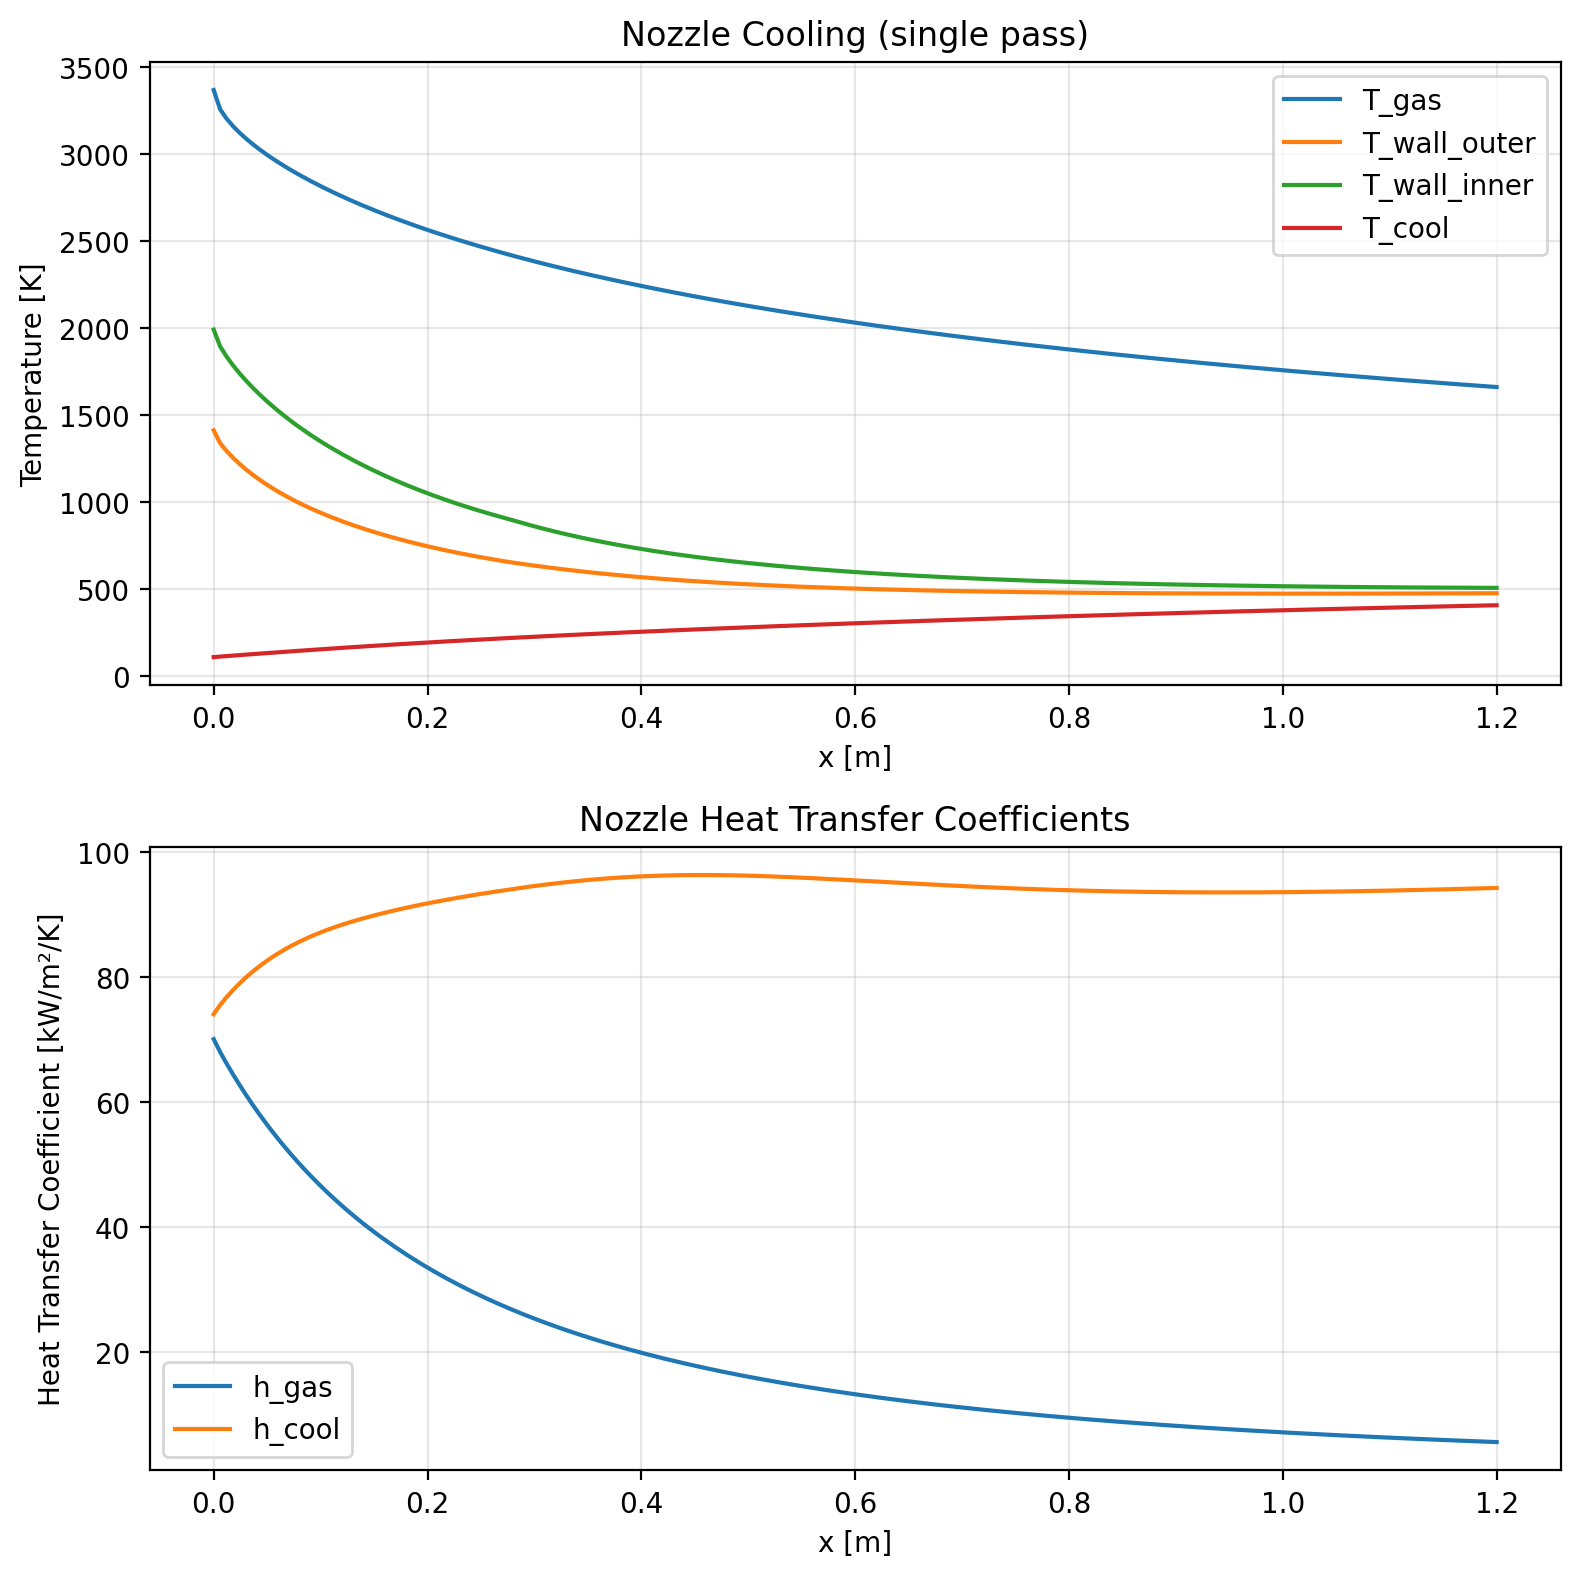

In [5]:
# Run a nozzle cooling test case with more realistic parameters
r_t = 0.10                    # Smaller throat radius
eps = 15.0
L_noz = 1.2                   # Shorter nozzle

x, r, A, At = regen.simple_conical_nozzle(r_t, eps, L_noz, N=200)

# Calculate the chamber state with Cantera
T0, gamma, R_g, _ = thermo.cantera_chamber_state(OF=OF, p0=p0)


# Mass flows for demonstration
F_vac = 5.0e5                 # Reduced thrust to 500 kN
Isp_vac_ideal, _, T_e, M_e = sweep.ideal_vacuum_isp_from_eps(p0, T0, gamma, R_g, eps)
Isp_eff = 0.95*Isp_vac_ideal
g0 = 9.80665
m_dot_total = F_vac/(Isp_eff*g0)
m_dot_fuel = m_dot_total/(1+OF)
m_dot_cool = 0.95*m_dot_fuel   # Use more coolant (50% of fuel flow)

print(f"Total mass flow: {m_dot_total:.2f} kg/s")
print(f"Coolant mass flow: {m_dot_cool:.2f} kg/s")

res_noz = regen.regen_nozzle_1D(
    x=x, r=r, A=A, At=At,
    p0=p0, T0=T0, gamma=gamma, R_g=R_g,
    coolant="Methane",
    coolant_props=regen.make_coolprop_liquid("Methane"),
    m_dot_cool=m_dot_cool,
    n_channels=300,            # More channels
    w_channel=0.003,           # Wider channels
    h_channel=0.004,           # Taller channels
    wall_thickness=0.0015,     # Thinner wall for better heat transfer
    roughness=5e-6,
    T_cool_in=110.0,
    p_cool_in=30e6,            # Higher inlet pressure (30 MPa)
    L_regen=L_noz,             # Cool entire nozzle
)

print(f"\nMax wall temperature: {res_noz['T_wall_inner'].max():.1f} K")
print(f"Min coolant pressure: {res_noz['p_cool'].min()/1e6:.2f} MPa")
print(f"Max coolant temperature: {res_noz['T_cool'].max():.1f} K")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Left subplot: Temperature profiles
ax1.plot(res_noz["x"], res_noz["T_g"], label="T_gas")
ax1.plot(res_noz["x"], res_noz["T_wall_outer"], label="T_wall_outer")
ax1.plot(res_noz["x"], res_noz["T_wall_inner"], label="T_wall_inner")
ax1.plot(res_noz["x"], res_noz["T_cool"], label="T_cool")
ax1.set_xlabel("x [m]")
ax1.set_ylabel("Temperature [K]")
ax1.legend()
ax1.set_title("Nozzle Cooling (single pass)")
ax1.grid(alpha=0.3)

# Right subplot: Heat transfer coefficients
ax2.plot(res_noz["x"], res_noz["h_gas"]/1000, label="h_gas")
ax2.plot(res_noz["x"], res_noz["h_cool"]/1000, label="h_cool")
ax2.set_xlabel("x [m]")
ax2.set_ylabel("Heat Transfer Coefficient [kW/m²/K]")
ax2.legend()
ax2.set_title("Nozzle Heat Transfer Coefficients")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Full-Flow Staged Combustion (FFSC) Cycle Simulation

In [6]:
# Run full FFSC cycle analysis with adjusted parameters for feasibility
summary = cycle.ffsc_full_flow_cycle(
    F_vac=F_vac,
    p0=p0,
    OF=OF,
    r_t=r_t,
    eps=eps,
    L_noz=L_noz,
    # Propellant specification
    fuel_name="CH4",               # Cantera species name
    ox_name="O2",                  # Cantera species name
    fuel_coolprop="Methane",       # CoolProp fluid name
    ox_coolprop="Oxygen",          # CoolProp fluid name
    T_fuel_tank=110.0,             # Fuel tank temperature (K)
    T_ox_tank=90.0,                # Oxidizer tank temperature (K)
    # Cooling parameters from our nozzle test
    n_channels=300,
    w_channel=0.003,
    wall_thickness=0.0015,
    p_cool_in=30e6,
    # Cycle parameters adjusted for feasibility
    T_turb_out=1000.0,         # Turbine exit temp much lower than preburner temp
    coolant_fraction_override=0.95,  # Use 95% of fuel flow for cooling
    eta_pump_fuel=0.75,        # Slightly higher pump efficiency
    eta_pump_ox=0.75,
    eta_turb_fuel=0.92,        # Slightly higher turbine efficiency
    eta_turb_ox=0.92,
    injector_dp_frac=0.15,     # Reduced from 0.2 - lower injector pressure drop
    feed_line_dp=0.5e6,        # Reduced from 1.0 MPa - lower feed line losses
)

print("\n=== FFSC Cycle Summary ===\n")

# Organize output by category
print("Performance:")
print(f"  F_vac                : {summary['F_vac']/1e3:.1f} kN")
print(f"  Isp_vac_eff          : {summary['Isp_vac_eff']:.1f} s")
print(f"  Isp_vac_ideal        : {summary['Isp_vac_ideal']:.1f} s")
print(f"  Efficiency           : {summary['Isp_vac_eff']/summary['Isp_vac_ideal']*100:.1f}%")

print("\nMass Flows:")
print(f"  m_dot_total          : {summary['m_dot_total']:.2f} kg/s")
print(f"  m_dot_fuel           : {summary['m_dot_fuel']:.2f} kg/s")
print(f"  m_dot_ox             : {summary['m_dot_ox']:.2f} kg/s")
print(f"  m_dot_cool           : {summary['m_dot_cool']:.2f} kg/s")
print(f"  Coolant fraction     : {summary['coolant_fraction']:.1%}")

print("\nChamber State:")
print(f"  T0                   : {summary['T0']:.0f} K")
print(f"  p0                   : {p0/1e6:.1f} MPa")
print(f"  gamma                : {summary['gamma']:.3f}")
print(f"  O/F ratio            : {OF:.2f}")

print("\nCooling:")
print(f"  T_wall_max           : {summary['T_wall_max']:.0f} K")
print(f"  dp_cool              : {summary['dp_cool']/1e6:.2f} MPa")

print("\nPressure Rises:")
print(f"  dp_fuel              : {summary['dp_fuel']/1e6:.2f} MPa")
print(f"  dp_ox                : {summary['dp_ox']/1e6:.2f} MPa")

print("\nPump Power Required:")
print(f"  P_pump_fuel          : {summary['P_pump_fuel']/1e6:.3f} MW")
print(f"  P_pump_ox            : {summary['P_pump_ox']/1e6:.3f} MW")
print(f"  P_turb_req_fuel      : {summary['P_turb_req_fuel']/1e6:.3f} MW")
print(f"  P_turb_req_ox        : {summary['P_turb_req_ox']/1e6:.3f} MW")

print("\nPreburner Temperatures:")
print(f"  T_pb_fuel            : {summary['T_pb_fuel']:.0f} K")
print(f"  T_pb_ox              : {summary['T_pb_ox']:.0f} K")

print("\nTurbine Power Available:")
print(f"  P_turb_avail_fuel    : {summary['P_turb_avail_fuel']/1e6:.3f} MW")
print(f"  P_turb_avail_ox      : {summary['P_turb_avail_ox']/1e6:.3f} MW")

print("\nFeasibility:")
fuel_margin = (summary['P_turb_avail_fuel'] - summary['P_turb_req_fuel'])/summary['P_turb_req_fuel']*100
ox_margin = (summary['P_turb_avail_ox'] - summary['P_turb_req_ox'])/summary['P_turb_req_ox']*100
print(f"  Fuel side margin     : {fuel_margin:+.1f}%")
print(f"  Ox side margin       : {ox_margin:+.1f}%")
print(f"  fuel_side_ok         : {bool(summary['fuel_side_ok'])}")
print(f"  ox_side_ok           : {bool(summary['ox_side_ok'])}")

if summary['fuel_side_ok'] and summary['ox_side_ok']:
    print("\n✓ FFSC cycle is FEASIBLE - both turbopump sides can be balanced!")
else:
    print("\n✗ FFSC cycle is NOT feasible - turbines cannot provide sufficient power")


=== FFSC Cycle Summary ===

Performance:
  F_vac                : 500.0 kN
  Isp_vac_eff          : 302.8 s
  Isp_vac_ideal        : 318.8 s
  Efficiency           : 95.0%

Mass Flows:
  m_dot_total          : 168.37 kg/s
  m_dot_fuel           : 40.09 kg/s
  m_dot_ox             : 128.28 kg/s
  m_dot_cool           : 38.08 kg/s
  Coolant fraction     : 95.0%

Chamber State:
  T0                   : 3703 K
  p0                   : 20.0 MPa
  gamma                : 1.196
  O/F ratio            : 3.20

Cooling:
  T_wall_max           : 1613 K
  dp_cool              : 20.24 MPa

Pressure Rises:
  dp_fuel              : 43.64 MPa
  dp_ox                : 23.40 MPa

Pump Power Required:
  P_pump_fuel          : 5.491 MW
  P_pump_ox            : 3.504 MW
  P_turb_req_fuel      : 5.603 MW
  P_turb_req_ox        : 3.576 MW

Preburner Temperatures:
  T_pb_fuel            : 3669 K
  T_pb_ox              : 3578 K

Turbine Power Available:
  P_turb_avail_fuel    : 214.033 MW
  P_turb_avail_ox    

## Cycle Flow Sheet

In [8]:
import os, subprocess, shutil
from IPython.display import Image, SVG, display
from mermaid import Mermaid # Make sure Mermaid is imported

# Dynamically generate Mermaid diagram from FFSC cycle results
use_svg = True
mmd_path = "ffsc_schematic.mmd"
out_svg = "ffsc_schematic.svg"
out_png = "ffsc_schematic.png"

# Extract key values from summary
m_dot_fuel_val = summary['m_dot_fuel']
m_dot_ox_val = summary['m_dot_ox']
m_dot_cool_val = summary['m_dot_cool']
dp_fuel_val = summary['dp_fuel'] / 1e6  # MPa
dp_ox_val = summary['dp_ox'] / 1e6  # MPa
dp_cool_val = summary['dp_cool'] / 1e6  # MPa
T_pb_fuel_val = summary['T_pb_fuel']
T_pb_ox_val = summary['T_pb_ox']
T_wall_max_val = summary['T_wall_max']
T_turb_exit = 1000.0  # From our T_turb_out parameter
dT_fuel_turb = T_pb_fuel_val - T_turb_exit
dT_ox_turb = T_pb_ox_val - T_turb_exit
T_cool_out = summary['nozzle_results']['T_cool'][-1]  # Exit coolant temp
dT_cool = T_cool_out - 110.0
T0_val = summary['T0']
p0_val = p0 / 1e6  # MPa
p_cool_in_val = 30.0  # MPa (from cycle analysis parameters)
eps_val = eps
Isp_val = summary['Isp_vac_eff']
F_vac_val = summary['F_vac'] / 1e3  # kN
OF_val = OF

# Calculate equivalence ratios (phi) for preburners
phi_fuel_pb = 1.3  # Fuel-rich
phi_ox_pb = 0.7  # Ox-rich

# Estimate preburner flows (small fractions for preburners)
# FFSC: all propellant goes through preburners, but we can estimate split
m_dot_fuel_to_cool = m_dot_cool_val
m_dot_fuel_to_pb = m_dot_fuel_val - m_dot_fuel_to_cool

# For fuel-rich preburner: mostly fuel, small amount of ox
# Stoichiometric O/F for CH4/O2 is ~4.0, so phi=1.3 means excess fuel
# O/F_pb_fuel = 4.0/1.3 ≈ 3.08
OF_pb_fuel = 4.0 / phi_fuel_pb
m_dot_ox_to_fuel_pb = m_dot_fuel_to_pb * OF_pb_fuel / (1 + OF_pb_fuel)
m_dot_fuel_to_fuel_pb = m_dot_fuel_to_pb / (1 + OF_pb_fuel)

# For ox-rich preburner: mostly ox, small amount of fuel
# phi=0.7 means excess oxidizer
# O/F_pb_ox = 4.0/0.7 ≈ 5.71
OF_pb_ox = 4.0 / phi_ox_pb
m_dot_ox_to_ox_pb = m_dot_ox_val - m_dot_ox_to_fuel_pb
m_dot_fuel_to_ox_pb = m_dot_ox_to_ox_pb / OF_pb_ox

# Remaining oxidizer goes to chamber
m_dot_ox_to_chamber = m_dot_ox_val - m_dot_ox_to_fuel_pb - m_dot_ox_to_ox_pb

# Pressures after pumps
p_fuel_pump_out = p0_val + dp_fuel_val
p_ox_pump_out = p0_val + dp_ox_val
p_cool_out = p_cool_in_val - dp_cool_val

mermaid_code = f"""%%{{init: {{'theme':'default','themeVariables': {{'lineColor':'#333333','primaryTextColor':'#000000'}}}}}}%%
graph LR
    %% Fuel side (top row)
    LCH4[LCH4 Tank<br/>T = 110 K<br/>ṁ = {m_dot_fuel_val:.1f} kg/s]
    FuelPump[Fuel Pump<br/>ΔP = {dp_fuel_val:.1f} MPa<br/>p_out = {p_fuel_pump_out:.1f} MPa]
    FuelPB[Fuel-Rich<br/>Preburner<br/>φ = {phi_fuel_pb:.1f}<br/>T = {T_pb_fuel_val:.0f} K<br/>p = {p0_val:.0f} MPa]
    FuelTurb[Fuel Turbine<br/>T_in = {T_pb_fuel_val:.0f} K<br/>T_out = {T_turb_exit:.0f} K]

    %% Oxidizer side (bottom row)
    LOX[LOX Tank<br/>T = 90 K<br/>ṁ = {m_dot_ox_val:.1f} kg/s]
    OxPump[Oxidizer Pump<br/>ΔP = {dp_ox_val:.1f} MPa<br/>p_out = {p_ox_pump_out:.1f} MPa]
    OxPB[Ox-Rich<br/>Preburner<br/>φ = {phi_ox_pb:.1f}<br/>T = {T_pb_ox_val:.0f} K<br/>p = {p0_val:.0f} MPa]
    OxTurb[Oxidizer Turbine<br/>T_in = {T_pb_ox_val:.0f} K<br/>T_out = {T_turb_exit:.0f} K]

    %% Cooling system
    Jacket[Regenerative<br/>Cooling Jacket<br/>ΔP = {dp_cool_val:.1f} MPa<br/>T_out = {T_cool_out:.0f} K]

    %% Combustion chamber
    Chamber[Main Chamber<br/>O/F = {OF_val:.1f}<br/>T₀ = {T0_val:.0f} K<br/>p₀ = {p0_val:.0f} MPa]
    Nozzle[Nozzle<br/>ε = {eps_val:.0f}<br/>Isp = {Isp_val:.0f} s]
    Thrust[Thrust<br/>{F_vac_val:.0f} kN]

    %% Fuel flow paths (red/orange for fuel)
    LCH4 -->|{m_dot_fuel_val:.1f} kg/s<br/>110 K| FuelPump
    FuelPump -->|{m_dot_cool_val:.1f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| Jacket
    FuelPump -->|{m_dot_fuel_to_fuel_pb:.1f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| FuelPB
    Jacket -->|{m_dot_cool_val:.1f} kg/s<br/>{T_cool_out:.0f} K<br/>{p_cool_out:.1f} MPa| Chamber

    %% Oxidizer to fuel preburner (purple for cross-connections)
    OxPump -.->|{m_dot_ox_to_fuel_pb:.2f} kg/s<br/>{p_ox_pump_out:.1f} MPa| FuelPB
    FuelPB -->|{m_dot_fuel_to_fuel_pb + m_dot_ox_to_fuel_pb:.1f} kg/s<br/>{T_pb_fuel_val:.0f} K| FuelTurb
    FuelTurb -->|{m_dot_fuel_to_fuel_pb + m_dot_ox_to_fuel_pb:.1f} kg/s<br/>{T_turb_exit:.0f} K| Chamber

    %% Oxidizer flow paths (blue for oxidizer)
    LOX -->|{m_dot_ox_val:.1f} kg/s<br/>90 K| OxPump
    OxPump -->|{m_dot_ox_to_ox_pb:.1f} kg/s<br/>{p_ox_pump_out:.1f} MPa| OxPB
    OxPump -->|{m_dot_ox_to_chamber:.1f} kg/s<br/>{p_ox_pump_out:.1f} MPa| Chamber

    %% Fuel to ox preburner (purple for cross-connections)
    FuelPump -.->|{m_dot_fuel_to_ox_pb:.2f} kg/s<br/>{p_fuel_pump_out:.1f} MPa| OxPB
    OxPB -->|{m_dot_ox_to_ox_pb + m_dot_fuel_to_ox_pb:.1f} kg/s<br/>{T_pb_ox_val:.0f} K| OxTurb
    OxTurb -->|{m_dot_ox_to_ox_pb + m_dot_fuel_to_ox_pb:.1f} kg/s<br/>{T_turb_exit:.0f} K| Chamber

    %% Power transmission (mechanical coupling - green dashed)
    FuelTurb -.->|Shaft Power<br/>{summary['P_turb_avail_fuel']/1e6:.2f} MW| FuelPump
    OxTurb -.->|Shaft Power<br/>{summary['P_turb_avail_ox']/1e6:.2f} MW| OxPump

    %% Exhaust (hot gas - yellow/orange)
    Chamber --> Nozzle
    Nozzle --> Thrust

    %% Styling for white background
    classDef fuel fill:#ffcccc,stroke:#cc0000,stroke-width:3px,color:#000000
    classDef ox fill:#cce5ff,stroke:#0066cc,stroke-width:3px,color:#000000
    classDef hot fill:#ffe6cc,stroke:#ff6600,stroke-width:3px,color:#000000
    classDef chamber fill:#fff4cc,stroke:#cc9900,stroke-width:4px,color:#000000
    class LCH4,FuelPump,FuelPB,FuelTurb,Jacket fuel
    class LOX,OxPump,OxPB,OxTurb ox
    class Chamber,Nozzle chamber

    %% Link colors for visibility on white background
    linkStyle 0,1,2,3,5,6 stroke:#cc0000,stroke-width:3px
    linkStyle 7,8,9,11,12 stroke:#0066cc,stroke-width:3px
    linkStyle 4,10 stroke:#9900cc,stroke-width:2px
    linkStyle 13,14 stroke:#009900,stroke-width:2px
    linkStyle 15,16 stroke:#ff6600,stroke-width:3px
"""

# Write the Mermaid source
with open(mmd_path, "w") as f:
    f.write(mermaid_code)

# Ensure mermaid-cli (mmdc) is available (not strictly needed for display here, but good for export)
mmdc = shutil.which("mmdc")
if mmdc is None:
    print("Warning: Mermaid CLI 'mmdc' not found. File export (SVG/PNG) may fail. Install with: npm install -g @mermaid-js/mermaid-cli")

# Display the Mermaid diagram directly in the notebook
display(Mermaid(mermaid_code))


## Cycle Optimizer -- Not working . . . still a work in Progress

In [9]:
# Optimizer still needs debugging -- seems to hang on the use of a negative pressure in CoolProp but still a work in progress


result = optimize_ffsc_design(
    F_vac=500e3,              # 500 kN thrust
    fuel_name="CH4",
    ox_name="O2",
    fuel_coolprop="Methane",
    ox_coolprop="Oxygen",
    T_fuel_tank=110.0,
    T_ox_tank=90.0,
    p_amb=0.0,                # Vacuum
    T_wall_max_limit=900.0,
    verbose=True,
)

print(f"Optimal Isp: {result['Isp_opt']:.2f} s")
print(f"Optimal p0: {result['p0_opt']/1e6:.2f} MPa")
print(f"Optimal O/F: {result['OF_opt']:.3f}")


Starting FFSC Design Optimization
Target thrust: 500.0 kN
Propellants: CH4/O2
Tank temps: T_fuel=110.0 K, T_ox=90.0 K
Ambient pressure: 0.0 kPa
Wall temp limit: 900.0 K

Bounds:
  p0:           10.0 - 35.0 MPa
  OF:           2.00 - 4.50
  r_t:          50.0 - 200.0 mm
  eps:          10.0 - 30.0
  L_noz:        0.50 - 2.50 m
  coolant_frac: 10.0% - 99.0%

Initial guess:
  p0=22.5 MPa, OF=3.25, r_t=125.0 mm, eps=20.0, L_noz=1.50 m, coolant_frac=54.5%

--- Testing initial guess ---
  Eval   1: ✗ FAILED - ValueError: Inputs in Brent [0.000000,30417.384000] do not bracket the r
⚠ WARNING: Initial guess produced invalid result (obj=1.00e+06)
  This may indicate a problem with input parameters or bounds.
  Attempting optimization anyway...


  Eval   2: ✗ FAILED - ValueError: Inputs in Brent [0.000000,30417.384000] do not bracket the r
  Eval   3: ✗ FAILED - ValueError: Inputs in Brent [0.000000,30417.384000] do not bracket the r
  Eval   4: ✗ FAILED - ValueError: Inputs in Brent [0.000000